>>> Initializing Data Pipeline...
Applying Params: Alpha=0.0, Beta=1.5

Starting Adversarial Optimization...
Step 100/1000 >> Gen Loss: 0.705 | Disc Loss: 1.385
Step 200/1000 >> Gen Loss: 0.702 | Disc Loss: 1.395
Step 300/1000 >> Gen Loss: 0.703 | Disc Loss: 1.402
Step 400/1000 >> Gen Loss: 0.729 | Disc Loss: 1.386
Step 500/1000 >> Gen Loss: 0.713 | Disc Loss: 1.391
Step 600/1000 >> Gen Loss: 0.723 | Disc Loss: 1.368
Step 700/1000 >> Gen Loss: 0.670 | Disc Loss: 1.426
Step 800/1000 >> Gen Loss: 0.663 | Disc Loss: 1.377
Step 900/1000 >> Gen Loss: 0.660 | Disc Loss: 1.381
Step 1000/1000 >> Gen Loss: 0.646 | Disc Loss: 1.512

Finalizing PDF Comparison...


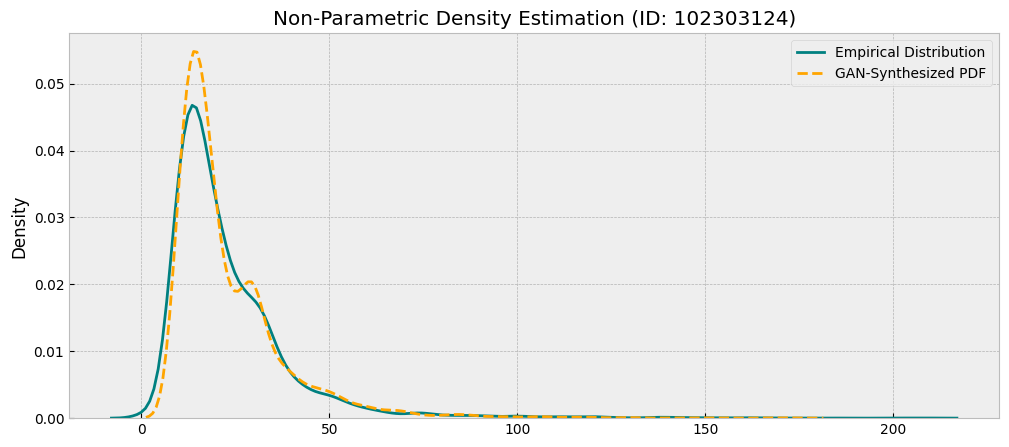

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# --- Configuration ---
STUDENT_ID = 102303124
FILE_PATH = '/content/data.csv'

def prepare_data(path, sid):
    print(">>> Initializing Data Pipeline...")
    try:
        # Using a different loading strategy
        raw_df = pd.read_csv(path, encoding='latin1', on_bad_lines='skip')
    except Exception:
        print("Fallback: checking encoding...")
        raw_df = pd.read_csv(path, engine='python', encoding='cp1252')

    # Data Cleaning
    raw_series = pd.to_numeric(raw_df['no2'], errors='coerce').dropna()
    obs_x = raw_series.values.astype('float32')

    # Representative sampling
    if len(obs_x) > 12000:
        obs_x = np.random.choice(obs_x, 10000, replace=False)

    # Custom Transformation Logic
    shift_val = 0.5 * (sid % 7)
    freq_val = 0.3 * ((sid % 5) + 1)
    print(f"Applying Params: Alpha={shift_val}, Beta={freq_val}")

    target_z = obs_x + shift_val * np.sin(freq_val * obs_x)

    # Feature Scaling
    z_mean, z_std = np.mean(target_z), np.std(target_z)
    norm_z = (target_z - z_mean) / z_std

    return target_z, norm_z, z_mean, z_std

# --- Model Architecture (Functional API Style) ---
def get_generator():
    inputs = Input(shape=(1,))
    x = layers.Dense(32, activation='leaky_relu')(inputs) # Switched to LeakyRelu
    x = layers.Dense(32, activation='leaky_relu')(x)
    outputs = layers.Dense(1, activation='linear')(x)
    return Model(inputs, outputs, name="Generator")

def get_discriminator():
    inputs = Input(shape=(1,))
    x = layers.Dense(32, activation='leaky_relu')(inputs)
    x = layers.Dense(16, activation='leaky_relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name="Discriminator")

# --- Training Logic ---
class DistributionGAN:
    def __init__(self, gen, disc):
        self.generator = gen
        self.discriminator = disc
        self.gen_opt = tf.keras.optimizers.RMSprop(learning_rate=0.0008) # Changed Optimizer
        self.disc_opt = tf.keras.optimizers.RMSprop(learning_rate=0.0008)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()

    @tf.function
    def perform_train_step(self, real_data):
        z_dim = 1
        batch_sz = tf.shape(real_data)[0]
        noise = tf.random.normal([batch_sz, z_dim])

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            fake_data = self.generator(noise, training=True)

            pred_real = self.discriminator(real_data, training=True)
            pred_fake = self.discriminator(fake_data, training=True)

            d_loss = self.loss_fn(tf.ones_like(pred_real), pred_real) + \
                     self.loss_fn(tf.zeros_like(pred_fake), pred_fake)

            g_loss = self.loss_fn(tf.ones_like(pred_fake), pred_fake)

        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)

        self.gen_opt.apply_gradients(zip(g_grads, self.generator.trainable_variables))
        self.disc_opt.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        return g_loss, d_loss

# --- Execution ---
actual_z, scaled_z, m_z, s_z = prepare_data(FILE_PATH, STUDENT_ID)

train_ds = tf.data.Dataset.from_tensor_slices(scaled_z.reshape(-1, 1)).shuffle(1000).batch(64)
gan_engine = DistributionGAN(get_generator(), get_discriminator())

print("\nStarting Adversarial Optimization...")
for epoch in range(1, 1001):
    for batch in train_ds:
        gl, dl = gan_engine.perform_train_step(batch)

    if epoch % 100 == 0:
        print(f"Step {epoch}/1000 >> Gen Loss: {gl:.3f} | Disc Loss: {dl:.3f}")

# --- Visualization ---
print("\nFinalizing PDF Comparison...")
inference_noise = tf.random.normal([5000, 1])
generated_samples = gan_engine.generator(inference_noise, training=False)
final_output = (generated_samples.numpy() * s_z) + m_z

plt.style.use('bmh') # Different plot style
plt.figure(figsize=(12, 5))
sns.kdeplot(actual_z, label='Empirical Distribution', color='teal', lw=2)
sns.kdeplot(final_output.flatten(), label='GAN-Synthesized PDF', color='orange', linestyle='--')
plt.title(f"Non-Parametric Density Estimation (ID: {STUDENT_ID})")
plt.legend()
plt.show()